In [5]:
!pip install opencv-python-headless

     |████████████████████████████████| 49.9 MB 6.1 kB/s eta 0:00:01


# Определение возраста покупателей

## Исследовательский анализ данных

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

In [7]:
# Загружаем файл с метками возраста
labels_path = '/datasets/faces/labels.csv'
images_dir = '/datasets/faces/final_files/'


data = pd.read_csv(labels_path)

print(data.head())
print(f"Размер выборки: {data.shape}")

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
Размер выборки: (7591, 2)


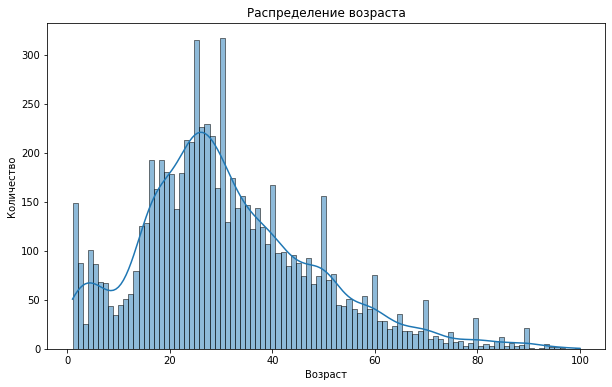

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(data['real_age'], bins=100, kde=True)
plt.title("Распределение возраста")
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.show()

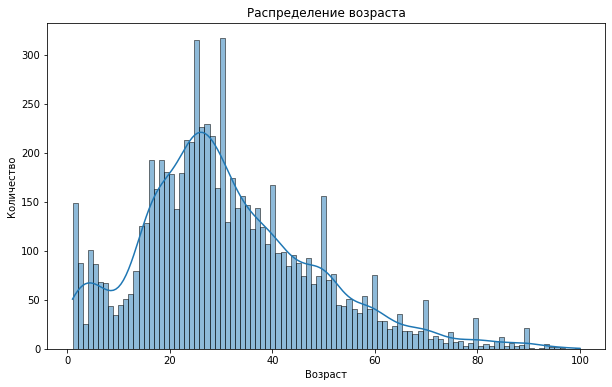

In [9]:
# РЕВЬЮЕР
plt.figure(figsize=(10, 6))
sns.histplot(data['real_age'], bins=100, kde=True)
plt.title("Распределение возраста")
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.show()

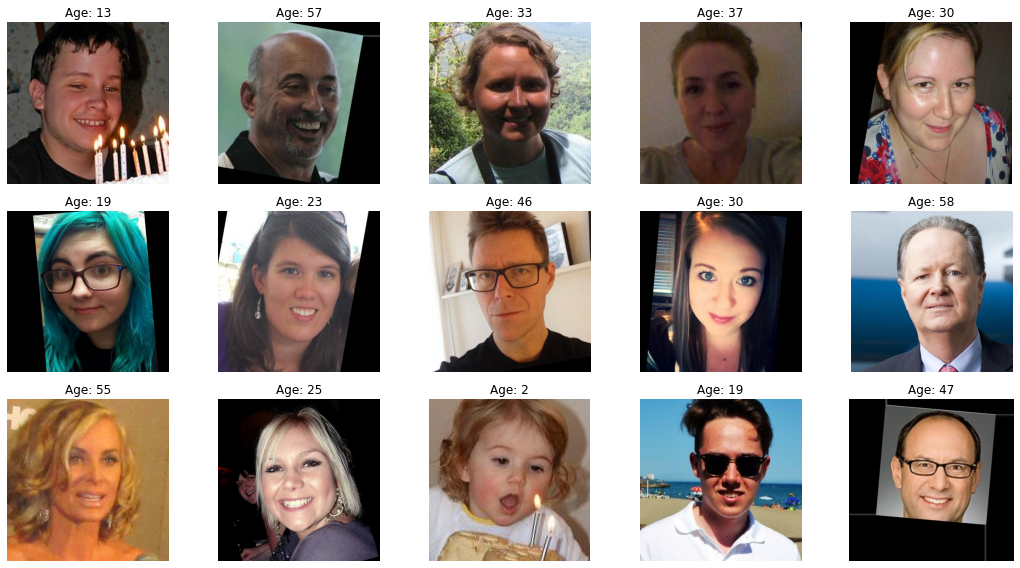

In [10]:
# Выбираем случайные изображения
sample_images = data.sample(15)

plt.figure(figsize=(15, 8))
for i, row in enumerate(sample_images.itertuples()):
    img_path = os.path.join(images_dir, row.file_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    plt.title(f"Age: {row.real_age}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Вывод

**Размер выборки даёт понять, сколько изображений можно использовать для обучения модели — это важно для её работы и точности предсказаний. График распределения возраста показал, что большинство фотографий — это люди в возрасте от 20 до 30 лет, а примеров для старших возрастных групп, особенно после 50 лет, гораздо меньше. Из-за этого модель может хуже предсказывать возраст пожилых людей, так как она будет больше "натренирована" на молодых. Когда мы напечатали 15 случайных фотографий, стало заметно, что качество изображений разное: где-то фон мешает, где-то есть тени или лица расположены под наклоном. Всё это может создать дополнительные сложности при обучении модели. Чтобы справиться с этим, на следующем этапе нужно будет привести изображения к единому формату и добавить аугментацию — например, повороты, сдвиги и настройку яркости, чтобы сделать модель устойчивее и улучшить предсказания для всех возрастных групп.**

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
    rescale=1./255,              
    rotation_range=20,          
    horizontal_flip=True,                   
    width_shift_range=0.1,      
    height_shift_range=0.1,   
    validation_split=0.2           
)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```

Train for 380 steps, validate for 119 steps
Epoch 1/10
380/380 - 138s - loss: 248.9548 - mae: 11.5790 - val_loss: 604.8706 - val_mae: 19.6017

Epoch 2/10
380/380 - 126s - loss: 127.5191 - mae: 8.6452 - val_loss: 149.4402 - val_mae: 9.1033

Epoch 3/10
380/380 - 132s - loss: 109.9401 - mae: 8.0191 - val_loss: 189.2367 - val_mae: 10.5343

Epoch 4/10
380/380 - 132s - loss: 98.3858 - mae: 7.5751 - val_loss: 96.9443 - val_mae: 7.7800

Epoch 5/10
380/380 - 134s - loss: 88.4255 - mae: 7.2136 - val_loss: 159.6442 - val_mae: 9.5022

Epoch 6/10
380/380 - 134s - loss: 82.9509 - mae: 6.9446 - val_loss: 103.9026 - val_mae: 7.4016

Epoch 7/10
380/380 - 132s - loss: 73.9695 - mae: 6.5725 - val_loss: 83.1311 - val_mae: 6.8323

Epoch 8/10
380/380 - 134s - loss: 66.9805 - mae: 6.2343 - val_loss: 99.5353 - val_mae: 7.6915

Epoch 9/10
380/380 - 130s - loss: 64.6664 - mae: 6.1557 - val_loss: 100.4676 - val_mae: 7.6964

Epoch 10/10
380/380 - 130s - loss: 58.9627 - mae: 5.8996 - val_loss: 94.1059 - val_mae: 7.1811

```

## Анализ обученной модели

**Для решения задачи была использована свёрточная нейронная сеть на основе ResNet50. В результате обучения за 10 эпох MAE удалось снизить с 11.6 до 5.9 на обучающей выборке и с 19.6 до 7.18 на валидационной. Модель продемонстрировала стабильное улучшение качества и уменьшение ошибки на обоих наборах данных, что говорит о её эффективности при обучении на небольшом объеме выборки.**

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы